## Argo Test

In this notebook I'm attempting to replicate some of the glider results with Argo data in the region of 30E-40E and 50S-55S.

In [2]:
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()
import scipy.ndimage as filter
filter.gaussian_filter1d

<function scipy.ndimage._filters.gaussian_filter1d(input, sigma, axis=-1, order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)>

## Load Points, Make Profiles, Remove Profiles with Sampling Frequency Less Than 2m

In [7]:
ds = argo_loader.region([30,40,-55,-50, 200,1500]).to_xarray()

In [8]:
def get_ds_interp(ds,depth_max,sample_rate):
    ds_prof=ds.argo.point2profile()
    median_dp=ds_prof.PRES.where(ds_prof.PRES<depth_max).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_rate,drop=True).N_PROF
    ds_sel=ds_prof.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(200,900,2))
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    return ds_interp

In [23]:
CT_interp=get_ds_interp(ds,1000,3)

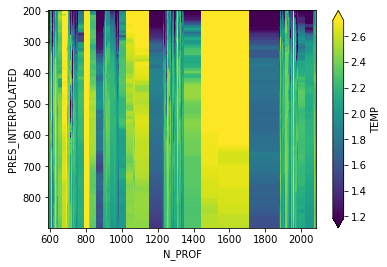

In [24]:
CT_interp.TEMP.plot(y='PRES_INTERPOLATED',robust=True)
plt.gca().invert_yaxis()

## Filtering Analysis

In [34]:
def get_ds_filt(ds,first,last,step):
    quant=int((last-first)/step)+1
    temp=np.zeros((CT.N_PROF.shape[0],CT.PRES_INTERPOLATED.shape[0],quant))
    filter_scales=np.zeros((quant))

    for n,sig in enumerate(range(first,last+1,step)):
        sigma=sig/4/np.sqrt(12)
        temp[:,:,n]=filter.gaussian_filter1d(CT,sigma=sigma,mode='nearest')
        filter_scales[n]=sig
    
    CT_filt=xr.DataArray(temp, dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
            coords={'N_PROF':CT.N_PROF,'PRES_INTERPOLATED':CT.PRES_INTERPOLATED,'FILT_SCALE':filter_scales})
    
    return CT_filt

In [36]:
CT_filt=get_ds_filt(CT_interp,10,300,5)

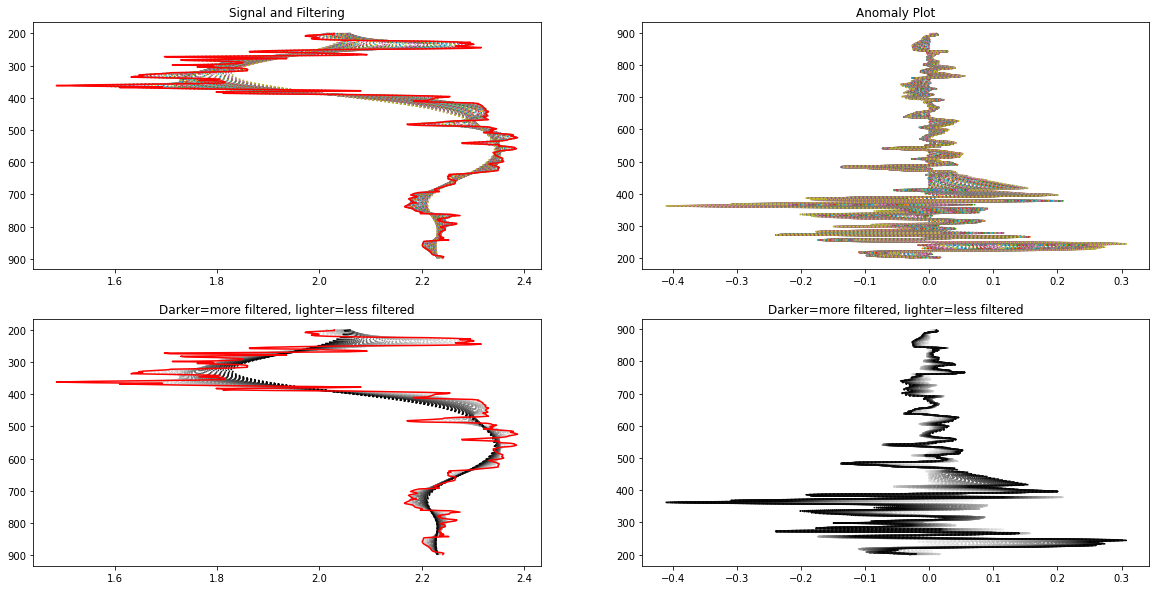

In [37]:
plt.figure(figsize=(20,10))
color=np.arange(0.01,1.01,1/quant)
color=np.flip(color,0)
prof_num=2080
prof=CT.sel(N_PROF=prof_num)

plt.subplot(2,2,1)
plt.plot(prof,prof.PRES_INTERPOLATED,color='red',zorder=100)
plt.gca().invert_yaxis()
plt.title("Signal and Filtering")

plt.subplot(2,2,2)
plt.title("Anomaly Plot")

plt.subplot(2,2,3)
plt.plot(prof,prof.PRES_INTERPOLATED,color='red',zorder=100)
plt.gca().invert_yaxis()
plt.title("Darker=more filtered, lighter=less filtered")

plt.subplot(2,2,4)
plt.title("Darker=more filtered, lighter=less filtered")

for n,sigma in enumerate(range(first, last+1, step)):
    filt=CT_filt.sel(N_PROF=prof_num,FILT_SCALE=sigma)
    anom=prof-filt
    
    plt.subplot(2,2,1)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,2)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':')
    
    plt.subplot(2,2,3)
    plt.plot(filt,filt.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))
    
    plt.subplot(2,2,4)
    plt.plot(anom,anom.PRES_INTERPOLATED,linestyle=':',color=str(color[n]))

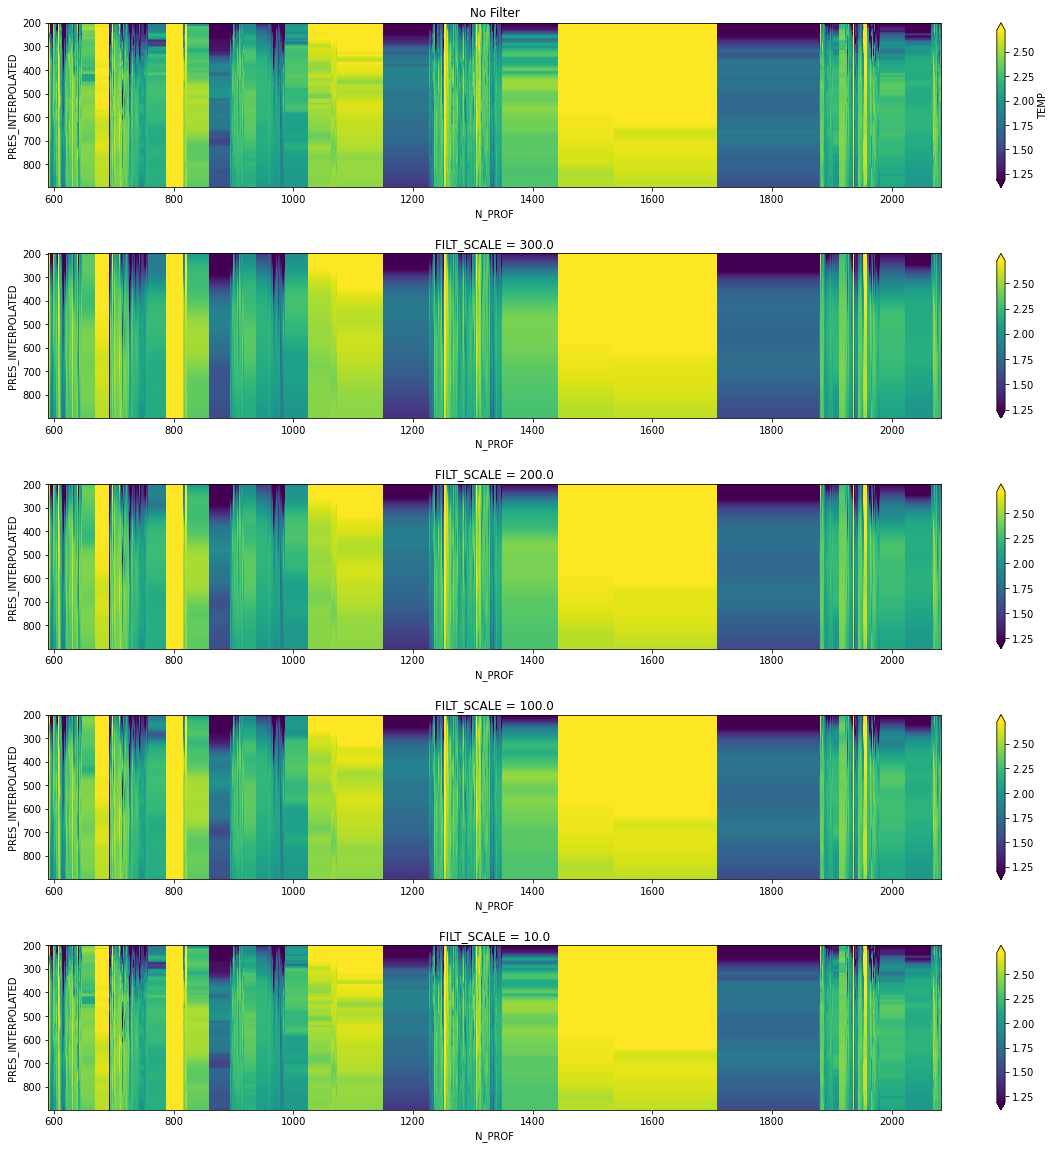

In [38]:
plt.figure(figsize=(20,20))
plt.subplot(5,1,1)
CT.plot(y='PRES_INTERPOLATED',robust=True)
plt.title("No Filter")
plt.gca().invert_yaxis()

for n,sig in enumerate([300,200,100,10]):
    filt=CT_filt.sel(FILT_SCALE=sig)
    plt.subplot(5,1,n+2)
    filt.plot(y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

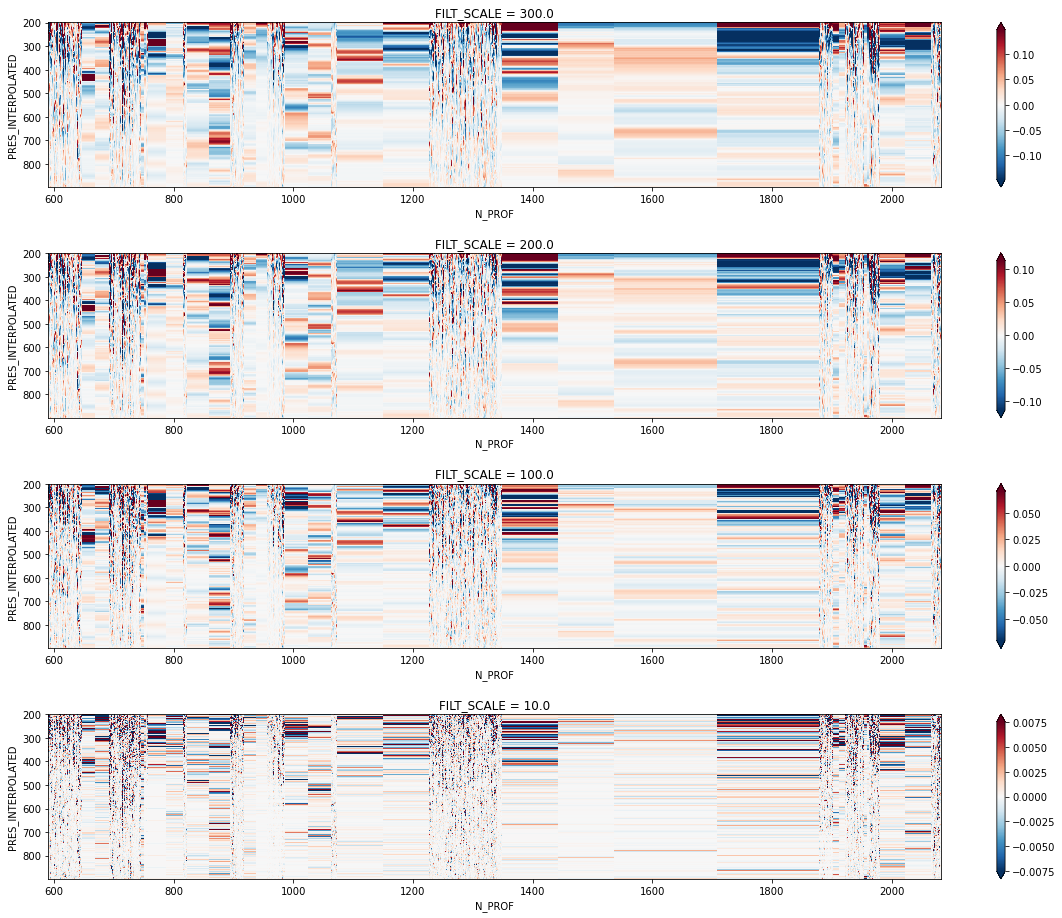

In [39]:
plt.figure(figsize=(20,20))

for n,sig in enumerate([300,200,100,10]):
    filt=CT_filt.sel(FILT_SCALE=sig)
    anom=filt-CT
    plt.subplot(5,1,n+1)
    anom.plot(y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.4)

In [40]:
var_scale=np.zeros(quant)

for n,sigma in enumerate(range(first,last+1,step)):
    prof=CT_filt.sel(FILT_SCALE=sigma)
    var_scale[n]=(prof-CT).var()

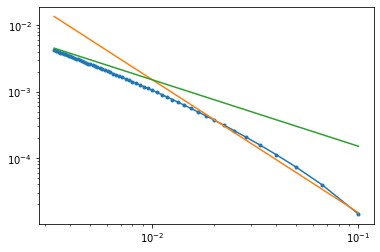

In [41]:
plt.plot(1/CT_filt.FILT_SCALE,var_scale,'.-')
plt.xscale('log')
plt.yscale('log')

x=1/CT_filt.FILT_SCALE
y_2=1.5*10**-7*x**-2
y_1=1.5*10**-5*x**-1

plt.plot(x,y_2)
plt.plot(x,y_1)

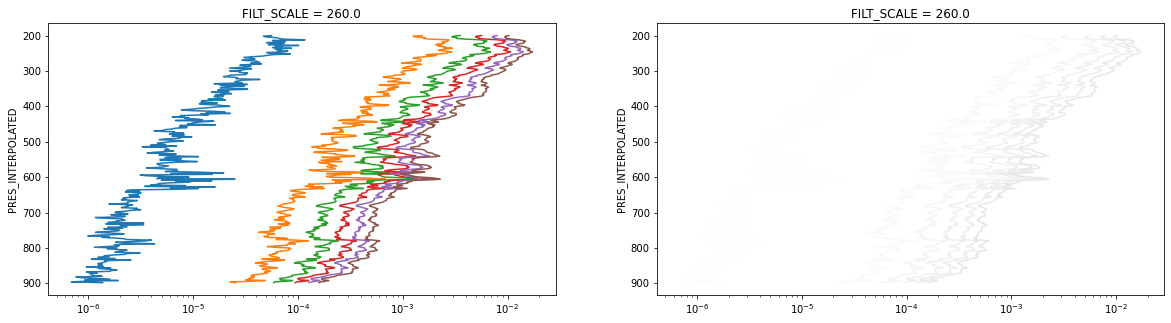

In [42]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.gca().invert_yaxis()
plt.xscale('log')

plt.subplot(1,2,2)
plt.gca().invert_yaxis()
plt.xscale('log')

for n,sig in enumerate(range(first,last+1,step*10)):
    prof=CT_filt.sel(FILT_SCALE=sig)
    
    plt.subplot(1,2,1)
    (prof-CT).var(['N_PROF']).plot(y='PRES_INTERPOLATED',label=sig)
    
    plt.subplot(1,2,2)
    (prof-CT).var(['N_PROF']).plot(y='PRES_INTERPOLATED',label=sigma,color=str(color[n]))

In [44]:
interp_1000_2=get_ds_interp(ds,1000,2)
interp_2000_2=get_ds_interp(ds,2000,2)
interp_1000_10=get_ds_interp(ds,1000,10)
interp_2000_10=get_ds_interp(ds,2000,10)

In [ ]:
filt_1000_2=get_ds_filt(interp_1000_2,10,300,5)
filt_2000_2=get_ds_filt(interp_2000_2,10,300,5)
filt_1000_10=get_ds_filt(interp_1000_10,10,300,5)
filt_1000_10=get_ds_filt(interp_2000_10,10,300,5)

In [33]:
filt_1000_2

<xarray.Dataset>
Dimensions:                (N_PROF: 6, PRES_INTERPOLATED: 350)
Coordinates:
  * N_PROF                 (N_PROF) int64 902 904 910 913 916 917
    LATITUDE               (N_PROF) float64 -53.27 -53.71 ... -53.56 -52.2
    LONGITUDE              (N_PROF) float64 37.42 37.29 38.66 38.35 33.09 32.72
    TIME                   (N_PROF) datetime64[ns] 2020-01-20T12:00:00 ... 20...
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) int64 200 202 204 ... 894 896 898
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int32 2 2 2 2 3 3
    CYCLE_NUMBER           (N_PROF) int32 103 105 112 118 159 160
    DATA_MODE              (N_PROF) <U1 'A' 'A' 'A' 'A' 'R' 'R'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 3901879 3901879 ... 3901888 3901888
    PRES                   (N_PROF, PRES_INTERPOLATED) float32 201.1 ... 898.0
    PSAL                   (N_PROF, PRES_INTERPOLATED) float32 34.24 ... 34.75
    TEMP                   (N_PROF, PRES_INTERPOLATED) float32 1.619 ... 2.095
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://erddap.ifremer.fr/erddap
    Fetched_by:           amf2288
    Fetched_date:         2022/07/14
    Fetched_constraints:  [x=30.00/40.00; y=-55.00/-50.00; z=200.0/1500.0]
    Fetched_uri:          ['https://erddap.ifremer.fr/erddap/tabledap/ArgoFlo...
    history:              Variables filtered according to DATA_MODE; Variable...

In [21]:
var_1000_2=np.zeros(quant)
var_2000_2=np.zeros(quant)
var_1000_10=np.zeros(quant)
var_2000_10=np.zeros(quant)

for n,sigma in enumerate(range(first,last+1,step)):
    #prof=CT_filt.sel(FILT_SCALE=sigma)
    #var_scale[n]=(prof-CT).var()
    
    prof_1000_2=ds_1000_2.sel(FILT_SCALE=sigma)
    var_1000_2[n]=(prof_1000_2-CT).var()

KeyError: 'FILT_SCALE is not a valid dimension or coordinate'

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)


plt.subplot(2,2,2)

plt.subplot(2,2,3)

plt.subplot(2,2,4)